In [1]:
import os
import pandas as pd
import tensorflow as tf

os.environ['TF_NUM_INTEROP_THREADS'] = '10'
os.environ['TF_NUM_INTRAOP_THREADS'] = '10'

# Configure TensorFlow session for multi-threading
tf.config.threading.set_inter_op_parallelism_threads(10)
tf.config.threading.set_intra_op_parallelism_threads(10)
# Ensure TensorFlow is using the Metal backend
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:

df = pd.read_csv('../data/balanced_classification_dataset.csv')
print(len(df))
df.head()

45257


,Unnamed: 0,patientid,sex,age,ANA,EXA,DIA_text,DIA_code,OP_text,OP_code,label,data
0,0,61.0,male,32.0,Beschwerden re. Achillessehne. NMR unauffällig...,Re. Achillessehne: Verdickung im Bereich der A...,Retropatellare Chondromalazie li; Insertionste...,M22.4,NaN,NaN,other,Beschwerden re. Achillessehne. NMR unauffällig...
1,1,67.0,male,41.0,Seit mehreren Monaten Beschwerden re. Achilles...,Re. Achillessehne: Deutliche Auftreibung der A...,V.a.laterale Chondromalazie bei st.n. Außenmen...,M23.3,NaN,NaN,meniskus_urgent,Seit mehreren Monaten Beschwerden re. Achilles...
2,2,72.0,male,19.0,. .Gestern beim Training stechende Schmerzen l...,Klinischer Befund des Oberschenkels li.deutl.V...,Z.n.arthroskopischer Chirurgie des Kniegelenkes.,M23.3,NaN,NaN,meniskus_urgent,. .Gestern beim Training stechende Schmerzen l...
3,3,72.0,male,23.0,beide Knie Schmerzen bei Treppe steigen oder L...,bd. Knie: frei Bewegl.; Patella o.B.; keine MZ...,Z.n.IM-Teilresektion re.,S83.2,NaN,NaN,meniskus_urgent,beide Knie Schmerzen bei Treppe steigen oder L...
4,4,84.0,male,57.0,(08.19 Uhr); bewegungsabhängig.Schmerzen wiede...,Klinischer Befund des Kniegelenks li.: Drucksc...,Beginnende Gonarthrose bds. li. mehr als re.,M17.9,NaN,NaN,other,(08.19 Uhr); bewegungsabhängig.Schmerzen wiede...


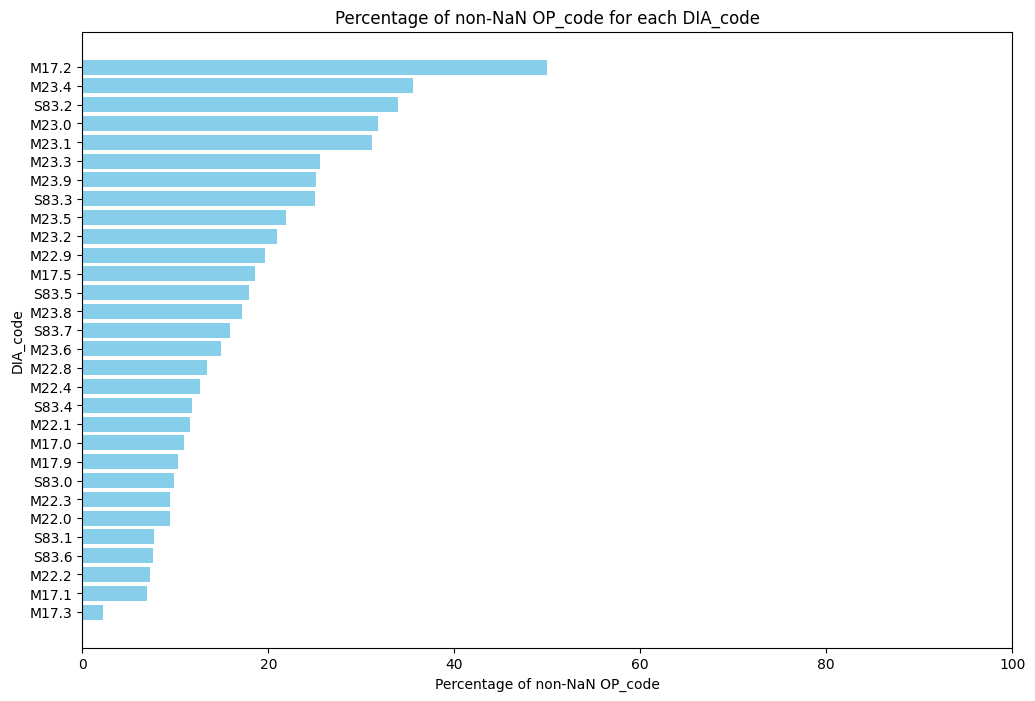

In [50]:
# Calculate the percentage of non-NaN OP_code for each DIA_code
df['DIA_code'] = df['DIA_code'].str[:5].to_frame()

percentage_non_nan = df.groupby('DIA_code')['OP_code'].apply(lambda x: x.notna().mean() * 100).reset_index()

# Rename the columns for better understanding
percentage_non_nan.columns = ['DIA_code', 'Percentage of non-NaN OP_code']

# Filter out DIA_code with 0% non-NaN OP_code
percentage_non_nan = percentage_non_nan[percentage_non_nan['Percentage of non-NaN OP_code'] > 0]

# Sort the values for better visualization
percentage_non_nan = percentage_non_nan.sort_values(by='Percentage of non-NaN OP_code', ascending=False)

# Plot the results using a horizontal bar plot
plt.figure(figsize=(12, 8))
plt.barh(percentage_non_nan['DIA_code'], percentage_non_nan['Percentage of non-NaN OP_code'], color='skyblue')
plt.xlabel('Percentage of non-NaN OP_code')
plt.ylabel('DIA_code')
plt.title('Percentage of non-NaN OP_code for each DIA_code')
plt.xlim(0, 100)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest percentage at the top
plt.show()

In [51]:
meniskus = [
    "M23.3",
    "S83.2", # Rupture
]
meniskus_low = [
    "M23.0", # Ganglion doesn't seem to urgent
    "M23.1", # something you have from birth
    "M23.2", # problems because of old rupture
    "M23.9"  # Same as M23.8
]
cruciate = [
    "M23.6", # Ruptur
    "S83.50", # might be rupture
    "S83.53", # Rupture
    "S83.54", # Rupture
    "S83.7" # Multiple areas
]
cruciate_low = [
    "M23.8", # Seems to be no rupture, rather weakness, still operations
    "S83.51", # Distorsion
    "S83.52", # Distorsion
]
other_urgent = [
    "S83.3" # Rupture Kniegelenkknorpel
    "S83.4" # Rupture Seitenband
]
other = [
    "M17",
    "M22",  
    "M23.4", # Freikörper, does have a lot of operations
    "M23.5", # instability
    "S83.1", # Only luxation
    "S83.6" # Distorsion somewhere
]

In [52]:
def createLabel(code):
    if any(elem in code for elem in meniskus):
        return "meniskus_urgent"
    elif any(elem in code for elem in meniskus_low):
        return "meniskus_low"
    elif any(elem in code for elem in cruciate):
        return "cruciate_urgent"
    elif any(elem in code for elem in cruciate_low):
        return "cruciate_low"
    elif any(elem in code for elem in other_urgent):
        return "other_urgent"
    elif any(elem in code for elem in other):
        return "other_minor"
    else:
        return "other_minor"
    
df['label'] = df['DIA_code'].apply(createLabel)

45257


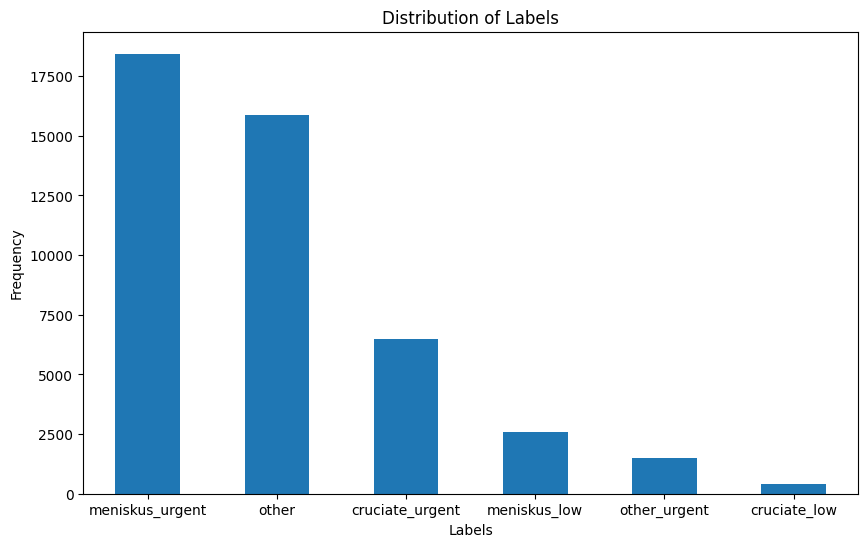

In [56]:
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
label_column = 'label'
cols = ['ANA', 'EXA', 'age', 'sex']
df['data'] = df[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df['data'].head()
# Get the minimum count of samples among all labels
min_count = df[label_column].value_counts().min()

# Create a new DataFrame with balanced samples
balanced_df = df # pd.concat([df[df['DIA_code'] == label].sample(min_count, random_state=42) for label in df['DIA_code'].unique()])
texts = balanced_df['data']

encoder = OneHotEncoder()
labels = encoder.fit_transform(df[label_column].to_frame()).toarray()
num_classes = len(encoder.categories_[0])
print(len(df))
label_counts = balanced_df[label_column].value_counts()

# Plot the distribution of labels
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [54]:
import numpy as np
from sklearn.utils import class_weight
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenize the texts
max_length = 400  # Length of input sequences
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Define model parameters
embedding_dim = 300  # Dimension of the embedding vectors
lstm_units = 128  # Number of LSTM units

# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = LSTM(lstm_units, return_sequences=True)(embedding)
x = Dropout(0.5)(x)
x = LSTM(lstm_units)(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Calculate class weights
labels_int = np.argmax(labels, axis=1)  # Convert one-hot encoded labels to integer labels
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels_int), y=labels_int)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
# Summary of the mod
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_11 (Embedding)        │ (None, 400, 300)       │    16,243,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 400, 128)       │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 400, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,595,377 (63.31 MB)

 Trainable params: 16,595,377 (63.31 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model.fit(padded_sequences, labels, epochs=100, batch_size=32, validation_split=0.2, class_weight=class_weights_dict)


Epoch 1/100
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 83s 73ms/step - accuracy: 0.1878 - loss: 1.5700 - val_accuracy: 0.4118 - val_loss: 1.5840
Epoch 2/100
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 68s 60ms/step - accuracy: 0.1642 - loss: 1.5605 - val_accuracy: 0.0409 - val_loss: 1.5826
Epoch 3/100
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 68s 60ms/step - accuracy: 0.1261 - loss: 1.5593 - val_accuracy: 0.0409 - val_loss: 1.5920
Epoch 4/100
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 69s 61ms/step - accuracy: 0.1028 - loss: 1.5574 - val_accuracy: 0.0811 - val_loss: 1.5975
Epoch 5/100
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 82s 72ms/step - accuracy: 0.1251 - loss: 1.5390 - val_accuracy: 0.0409 - val_loss: 1.5888
Epoch 6/100
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 76s 67ms/step - accuracy: 0.0948 - loss: 1.5675 - val_accuracy: 0.0409 - val_loss: 1.6079
Epoch 7/100
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 68s 60ms/step - accuracy: 0.1008 - loss: 1.5523 - val_accuracy: 0.0409 - val_loss: 1.5788
Epoch 8/100
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 68s 60ms/step - accuracy: 

KeyboardInterrupt: 

# Learning rate

In [18]:
from keras.src.optimizers.schedules import ExponentialDecay



from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenize the texts
max_length = 400  # Length of input sequences
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Define model parameters
embedding_dim = 300  # Dimension of the embedding vectors
lstm_units = 128  # Number of LSTM units

# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = LSTM(lstm_units, return_sequences=True)(embedding)
x = Dropout(0.5)(x)
x = LSTM(lstm_units)(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)
# Define the learning rate scheduler
initial_learning_rate = 0.01
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

# Compile the model with the learning rate scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the mod
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 400, 300)       │    10,424,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 400, 128)       │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 400, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,775,848 (41.11 MB)

 Trainable params: 10,775,848 (41.11 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.fit(padded_sequences, labels, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 28s 53ms/step - accuracy: 0.5212 - loss: 1.2439 - val_accuracy: 0.5582 - val_loss: 1.1756
Epoch 2/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - accuracy: 0.5419 - loss: 1.1932 - val_accuracy: 0.5582 - val_loss: 1.1703
Epoch 3/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - accuracy: 0.5444 - loss: 1.1884 - val_accuracy: 0.5582 - val_loss: 1.1685
Epoch 4/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - accuracy: 0.5478 - loss: 1.1828 - val_accuracy: 0.5582 - val_loss: 1.1718
Epoch 5/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - accuracy: 0.5456 - loss: 1.1865 - val_accuracy: 0.5582 - val_loss: 1.1703
Epoch 6/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - accuracy: 0.5423 - loss: 1.1908 - val_accuracy: 0.5582 - val_loss: 1.1690
Epoch 7/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - accuracy: 0.5438 - loss: 1.1881 - val_accuracy: 0.5582 - val_loss: 1.1712
Epoch 8/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - accuracy: 0.5436 - loss: 1.1887 - 

# Smaller

In [4]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenize the texts
max_length = 400  # Length of input sequences
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Define model parameters
embedding_dim = 300  # Dimension of the embedding vectors
lstm_units = 64  # Number of LSTM units

# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = LSTM(lstm_units, return_sequences=True)(embedding)
x = Dropout(0.5)(x)
x = LSTM(lstm_units)(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the mod
model.summary()


2024-07-17 23:28:41.952559: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-07-17 23:28:41.952589: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-07-17 23:28:41.952595: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-07-17 23:28:41.952607: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-17 23:28:41.952617: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 400, 300)       │    10,424,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 400, 64)        │        93,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 400, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,550,824 (40.25 MB)

 Trainable params: 10,550,824 (40.25 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
model.fit(padded_sequences, labels, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10


2024-07-17 23:28:42.430685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


510/510 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.5405 - loss: 1.2136 - val_accuracy: 0.5582 - val_loss: 1.1776
Epoch 2/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.5379 - loss: 1.2046 - val_accuracy: 0.5582 - val_loss: 1.1704
Epoch 3/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.5361 - loss: 1.2044 - val_accuracy: 0.5582 - val_loss: 1.1737
Epoch 4/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.5396 - loss: 1.1990 - val_accuracy: 0.5582 - val_loss: 1.1692
Epoch 5/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.5461 - loss: 1.1906 - val_accuracy: 0.5582 - val_loss: 1.1695
Epoch 6/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - accuracy: 0.5421 - loss: 1.1942 - val_accuracy: 0.5582 - val_loss: 1.1695
Epoch 7/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - accuracy: 0.5452 - loss: 1.1901 - val_accuracy: 0.5582 - val_loss: 1.1707
Epoch 8/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.5476 - loss: 1.1858 - val_accurac

## Bigger

In [6]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenize the texts
max_length = 400  # Length of input sequences
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Define model parameters
embedding_dim = 300  # Dimension of the embedding vectors
lstm_units = 256  # Number of LSTM units

# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = LSTM(lstm_units, return_sequences=True)(embedding)
x = Dropout(0.5)(x)
x = LSTM(lstm_units)(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the mod
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 400, 300)       │    10,424,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 400, 256)       │       570,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 400, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,520,808 (43.95 MB)

 Trainable params: 11,520,808 (43.95 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.fit(padded_sequences, labels, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 60s 117ms/step - accuracy: 0.5408 - loss: 1.2086 - val_accuracy: 0.5582 - val_loss: 1.1749
Epoch 2/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 50s 98ms/step - accuracy: 0.5401 - loss: 1.2002 - val_accuracy: 0.5582 - val_loss: 1.1691
Epoch 3/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 46s 89ms/step - accuracy: 0.5448 - loss: 1.1909 - val_accuracy: 0.5582 - val_loss: 1.1723
Epoch 4/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 39s 77ms/step - accuracy: 0.5360 - loss: 1.2013 - val_accuracy: 0.5582 - val_loss: 1.1697
Epoch 5/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 36s 71ms/step - accuracy: 0.5405 - loss: 1.1942 - val_accuracy: 0.5582 - val_loss: 1.1732
Epoch 6/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 37s 72ms/step - accuracy: 0.5407 - loss: 1.1982 - val_accuracy: 0.5582 - val_loss: 1.1693
Epoch 7/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 36s 71ms/step - accuracy: 0.5442 - loss: 1.1902 - val_accuracy: 0.5582 - val_loss: 1.1698
Epoch 8/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 36s 71ms/step - accuracy: 0.5485 - loss: 1.1868 -

## More layers

In [8]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenize the texts
max_length = 400  # Length of input sequences
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Define model parameters
embedding_dim = 300  # Dimension of the embedding vectors
lstm_units = 128  # Number of LSTM units

# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = LSTM(lstm_units, return_sequences=True)(embedding)
x = Dropout(0.5)(x)
x = LSTM(lstm_units, return_sequences=True)(x)
x = Dropout(0.5)(x)
x = LSTM(lstm_units, return_sequences=True)(x)
x = Dropout(0.5)(x)
x = LSTM(lstm_units)(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the mod
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 400, 300)       │    10,424,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 400, 128)       │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 400, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 400, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 400, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 400, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 400, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,039,016 (42.11 MB)

 Trainable params: 11,039,016 (42.11 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.fit(padded_sequences, labels, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 45s 85ms/step - accuracy: 0.5354 - loss: 1.2152 - val_accuracy: 0.5582 - val_loss: 1.1683
Epoch 2/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 43s 84ms/step - accuracy: 0.5436 - loss: 1.1974 - val_accuracy: 0.5582 - val_loss: 1.1755
Epoch 3/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 43s 84ms/step - accuracy: 0.5436 - loss: 1.1943 - val_accuracy: 0.5582 - val_loss: 1.1701
Epoch 4/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 43s 84ms/step - accuracy: 0.5471 - loss: 1.1885 - val_accuracy: 0.5582 - val_loss: 1.1711
Epoch 5/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 43s 84ms/step - accuracy: 0.5433 - loss: 1.1920 - val_accuracy: 0.5582 - val_loss: 1.1727
Epoch 6/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 43s 84ms/step - accuracy: 0.5448 - loss: 1.1896 - val_accuracy: 0.5582 - val_loss: 1.1700
Epoch 7/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 43s 84ms/step - accuracy: 0.5401 - loss: 1.1966 - val_accuracy: 0.5582 - val_loss: 1.1713
Epoch 8/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 43s 84ms/step - accuracy: 0.5396 - loss: 1.1968 - 

## Less layers

In [20]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenize the texts
max_length = 400  # Length of input sequences
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Define model parameters
embedding_dim = 300  # Dimension of the embedding vectors
lstm_units = 128  # Number of LSTM units

# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = LSTM(lstm_units)(embedding)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the mod
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, 400, 300)       │    10,424,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 128)            │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,644,264 (40.60 MB)

 Trainable params: 10,644,264 (40.60 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.fit(padded_sequences, labels, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.5468 - loss: 1.1932 - val_accuracy: 0.5582 - val_loss: 1.1696
Epoch 2/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.5391 - loss: 1.1959 - val_accuracy: 0.5582 - val_loss: 1.1697
Epoch 3/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.5516 - loss: 1.1802 - val_accuracy: 0.5582 - val_loss: 1.1771
Epoch 4/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.5429 - loss: 1.1899 - val_accuracy: 0.5582 - val_loss: 1.1697
Epoch 5/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.5383 - loss: 1.1955 - val_accuracy: 0.5582 - val_loss: 1.1732
Epoch 6/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.5417 - loss: 1.1913 - val_accuracy: 0.5582 - val_loss: 1.1715
Epoch 7/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.5429 - loss: 1.1893 - val_accuracy: 0.5582 - val_loss: 1.1710
Epoch 8/10
510/510 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.5438 - loss: 1.1888 - 

## More Epochs

In [12]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenize the texts
max_length = 400  # Length of input sequences
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Define model parameters
embedding_dim = 300  # Dimension of the embedding vectors
lstm_units = 128  # Number of LSTM units

# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = LSTM(lstm_units, return_sequences=True)(embedding)
x = Dropout(0.5)(x)
x = LSTM(lstm_units)(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the mod
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 400, 300)       │    10,424,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 400, 128)       │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 400, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,775,848 (41.11 MB)

 Trainable params: 10,775,848 (41.11 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.fit(padded_sequences, labels, epochs=100, batch_size=32, validation_split=0.2)


Epoch 1/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 28s 54ms/step - accuracy: 0.5368 - loss: 1.2145 - val_accuracy: 0.5582 - val_loss: 1.1855
Epoch 2/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - accuracy: 0.5435 - loss: 1.1985 - val_accuracy: 0.5582 - val_loss: 1.1730
Epoch 3/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - accuracy: 0.5487 - loss: 1.1842 - val_accuracy: 0.5582 - val_loss: 1.1688
Epoch 4/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 27s 54ms/step - accuracy: 0.5453 - loss: 1.1910 - val_accuracy: 0.5582 - val_loss: 1.1701
Epoch 5/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 28s 54ms/step - accuracy: 0.5401 - loss: 1.1966 - val_accuracy: 0.5582 - val_loss: 1.1695
Epoch 6/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - accuracy: 0.5392 - loss: 1.1960 - val_accuracy: 0.5582 - val_loss: 1.1694
Epoch 7/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - accuracy: 0.5379 - loss: 1.2008 - val_accuracy: 0.5582 - val_loss: 1.1693
Epoch 8/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - accuracy: 0.5359 - loss: 1

In [16]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenize the texts
max_length = 400  # Length of input sequences
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Define model parameters
embedding_dim = 300  # Dimension of the embedding vectors
lstm_units = 128  # Number of LSTM units

# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = LSTM(lstm_units, return_sequences=True)(embedding)
x = Dropout(0.5)(x)
x = LSTM(lstm_units)(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the mod
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 400, 300)       │    10,424,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 400, 128)       │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 400, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,775,848 (41.11 MB)

 Trainable params: 10,775,848 (41.11 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.fit(padded_sequences, labels, epochs=10, batch_size=128, validation_split=0.2)


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.5252 - loss: 1.2150 - val_accuracy: 0.5582 - val_loss: 1.1678
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.5464 - loss: 1.1907 - val_accuracy: 0.5582 - val_loss: 1.1706
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.5411 - loss: 1.1977 - val_accuracy: 0.5582 - val_loss: 1.1705
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.5459 - loss: 1.1905 - val_accuracy: 0.5582 - val_loss: 1.1758
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.5389 - loss: 1.1992 - val_accuracy: 0.5582 - val_loss: 1.1708
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.5473 - loss: 1.1886 - val_accuracy: 0.5582 - val_loss: 1.1686
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.5404 - loss: 1.1960 - val_accuracy: 0.5582 - val_loss: 1.1684
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.5468 - loss: 1.1863 - val_acc

In [18]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenize the texts
max_length = 400  # Length of input sequences
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Define model parameters
embedding_dim = 300  # Dimension of the embedding vectors
lstm_units = 128  # Number of LSTM units

# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = LSTM(lstm_units, return_sequences=True)(embedding)
x = Dropout(0.5)(x)
x = LSTM(lstm_units)(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the mod
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 400, 300)       │    10,424,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 400, 128)       │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 400, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,775,848 (41.11 MB)

 Trainable params: 10,775,848 (41.11 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.fit(padded_sequences, labels, epochs=10, batch_size=8, validation_split=0.2)


Epoch 1/10
2037/2037 ━━━━━━━━━━━━━━━━━━━━ 136s 66ms/step - accuracy: 0.5473 - loss: 1.2060 - val_accuracy: 0.5582 - val_loss: 1.1702
Epoch 2/10
2037/2037 ━━━━━━━━━━━━━━━━━━━━ 149s 73ms/step - accuracy: 0.5357 - loss: 1.2032 - val_accuracy: 0.5582 - val_loss: 1.1687
Epoch 3/10
2037/2037 ━━━━━━━━━━━━━━━━━━━━ 149s 73ms/step - accuracy: 0.5440 - loss: 1.1936 - val_accuracy: 0.5582 - val_loss: 1.1708
Epoch 4/10
2037/2037 ━━━━━━━━━━━━━━━━━━━━ 149s 73ms/step - accuracy: 0.5539 - loss: 1.1804 - val_accuracy: 0.5582 - val_loss: 1.1721
Epoch 5/10
2037/2037 ━━━━━━━━━━━━━━━━━━━━ 149s 73ms/step - accuracy: 0.5429 - loss: 1.1926 - val_accuracy: 0.5582 - val_loss: 1.1687
Epoch 6/10
2037/2037 ━━━━━━━━━━━━━━━━━━━━ 149s 73ms/step - accuracy: 0.5448 - loss: 1.1897 - val_accuracy: 0.5582 - val_loss: 1.1722
Epoch 7/10
2037/2037 ━━━━━━━━━━━━━━━━━━━━ 127s 62ms/step - accuracy: 0.5422 - loss: 1.1929 - val_accuracy: 0.5582 - val_loss: 1.1717
Epoch 8/10
2037/2037 ━━━━━━━━━━━━━━━━━━━━ 129s 63ms/step - accuracy: 

In [5]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Tokenize the texts
max_length = 400  # Length of input sequences
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Convert labels to categorical
num_classes = len(set(labels))
labels = to_categorical(labels, num_classes=num_classes)

# Define model parameters
embedding_dim = 300  # Dimension of the embedding vectors
lstm_units = 64  # Number of LSTM units

# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, trainable=True)(input_text)

# Two Bidirectional LSTM layers with recurrent dropout
x = Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(embedding)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Compute class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(labels.argmax(axis=1)), labels.argmax(axis=1))
class_weights = dict(enumerate(class_weights))

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)




TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
# Train the model
model.fit(padded_sequences, labels, epochs=10, batch_size=32, validation_split=0.2,
          class_weight=class_weights, callbacks=[early_stopping])

In [61]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, Concatenate, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Tokenize the texts
max_length = 400  # Length of input sequences
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Convert labels to categorical
labels = to_categorical(labels, num_classes=num_classes)

# Define model parameters
embedding_dim = 300  # Dimension of the embedding vectors
lstm_units = 64  # Number of LSTM units
conv_filters = 128  # Number of convolutional filters
kernel_size = 5  # Size of the convolution kernel

# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, trainable=True)(input_text)

# Convolutional layer
conv_layer = Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu')(embedding)
conv_layer = GlobalMaxPooling1D()(conv_layer)

# Two Bidirectional LSTM layers with recurrent dropout
lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(embedding)
lstm_layer = Dropout(0.5)(lstm_layer)
lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(lstm_layer)
lstm_layer = Dropout(0.5)(lstm_layer)

# Attention layer
attention_layer = AdditiveAttention()([lstm_layer, lstm_layer])

# Flatten the attention output
attention_output = GlobalMaxPooling1D()(attention_layer)

# Combine LSTM and Conv outputs
combined = Concatenate()([conv_layer, attention_output])

# Dense layer
dense_layer = Dense(64, activation='relu')(combined)
dense_layer = Dropout(0.5)(dense_layer)

# Output layer
output = Dense(num_classes, activation='softmax')(dense_layer)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()




Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 400)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_14        │ (None, 400, 300)  │ 16,243,800 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 400, 128)  │    186,880 │ embedding_14[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 400, 128)  │          0 │ bidirectional_4[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 400, 128)  │     98,816 │ dropout_27[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 400, 128)  │          0 │ bidirectional_5[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 396, 128)  │    192,128 │ embedding_14[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_attention… │ (None, 400, 128)  │        128 │ dropout_28[0][0], │
│ (AdditiveAttention) │                   │            │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ additive_attenti… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │     16,448 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 64)        │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 6)         │        390 │ dropout_29[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,738,590 (63.85 MB)

 Trainable params: 16,738,590 (63.85 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:

# Compute class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(df['label']), df['label'].argmax(axis=1))
class_weights = dict(enumerate(class_weights))

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


ValueError: `axis` must be fewer than the number of dimensions (1)

In [60]:
# Train the model
model.fit(padded_sequences, labels, epochs=10, batch_size=32, validation_split=0.2,
          class_weight=class_weights, callbacks=[early_stopping])

NameError: name 'early_stopping' is not defined

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, Concatenate, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Preprocessing
label_column = 'label'
cols = ['ANA', 'EXA', 'age', 'sex']
df['data'] = df[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# Balance the dataset (example, replace with actual balancing logic)
balanced_df = df # Replace with actual balancing logic
texts = balanced_df['data']

# Encode labels
encoder = OneHotEncoder()
labels = encoder.fit_transform(df[label_column].to_frame()).toarray()
num_classes = len(encoder.categories_[0])



# Tokenize the texts
max_length = 400  # Length of input sequences
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Compute class weights using non-categorical labels
original_labels = df[label_column].to_numpy()
class_weights = compute_class_weight('balanced', classes=np.unique(original_labels), y=original_labels)
class_weights = dict(enumerate(class_weights))

# Define model parameters
embedding_dim = 300  # Dimension of the embedding vectors
lstm_units = 64  # Number of LSTM units
conv_filters = 128  # Number of convolutional filters
kernel_size = 5  # Size of the convolution kernel

# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, trainable=True)(input_text)

# Convolutional layer
conv_layer = Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu')(embedding)
conv_layer = GlobalMaxPooling1D()(conv_layer)

# Two Bidirectional LSTM layers with recurrent dropout
lstm_layer = LSTM(lstm_units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(embedding)
lstm_layer = Dropout(0.5)(lstm_layer)
lstm_layer = LSTM(lstm_units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(lstm_layer)
lstm_layer = Dropout(0.5)(lstm_layer)

# Attention layer
attention_layer = AdditiveAttention()([lstm_layer, lstm_layer])

# Flatten the attention output
attention_output = GlobalMaxPooling1D()(attention_layer)

# Combine LSTM and Conv outputs
combined = Concatenate()([conv_layer, attention_output])

# Dense layer
dense_layer = Dense(64, activation='relu')(combined)
dense_layer = Dropout(0.5)(dense_layer)

# Output layer
output = Dense(num_classes, activation='softmax')(dense_layer)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model



2024-07-18 15:32:03.622274: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-07-18 15:32:03.622305: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-07-18 15:32:03.622310: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-07-18 15:32:03.622326: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-18 15:32:03.622339: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 400)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 400, 300)  │ 16,243,800 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 400, 64)   │     93,440 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 400, 64)   │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 400, 64)   │     33,024 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 400, 64)   │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 396, 128)  │    192,128 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_attention  │ (None, 400, 64)   │         64 │ dropout_1[0][0],  │
│ (AdditiveAttention) │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ additive_attenti… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     12,352 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 6)         │        390 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,575,198 (63.23 MB)

 Trainable params: 16,575,198 (63.23 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
model.fit(padded_sequences, labels, epochs=10, batch_size=32, validation_split=0.2,
          class_weight=class_weights, callbacks=[early_stopping])

Epoch 1/10


2024-07-18 15:32:04.439703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-07-18 15:32:09.364639: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INTERNAL: stream cannot wait for itself
	 [[{{node StatefulPartitionedCall/functional_1/lstm_1/while/body/_60/functional_1/lstm_1/while/gradient_tape/functional_1/lstm_1/while/gradients/functional_1/lstm_1/while/TensorArrayV2Read/TensorListGetItem_grad/TensorListElementShape/_216}}]]
2024-07-18 15:32:09.364660: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13273125454203060446
2024-07-18 15:32:09.364665: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8597514451725844752
2024-07-18 15:32:09.364676: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INTERNAL: strea

InternalError: Graph execution error:

Detected at node StatefulPartitionedCall/functional_1/lstm_1/while/body/_60/functional_1/lstm_1/while/gradient_tape/functional_1/lstm_1/while/gradients/functional_1/lstm_1/while/TensorArrayV2Read/TensorListGetItem_grad/TensorListElementShape/_216 defined at (most recent call last):
<stack traces unavailable>
Detected at node StatefulPartitionedCall/functional_1/lstm_1/while/body/_60/functional_1/lstm_1/while/gradient_tape/functional_1/lstm_1/while/gradients/functional_1/lstm_1/while/TensorArrayV2Read/TensorListGetItem_grad/TensorListElementShape/_216 defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INTERNAL:  stream cannot wait for itself
	 [[{{node StatefulPartitionedCall/functional_1/lstm_1/while/body/_60/functional_1/lstm_1/while/gradient_tape/functional_1/lstm_1/while/gradients/functional_1/lstm_1/while/TensorArrayV2Read/TensorListGetItem_grad/TensorListElementShape/_216}}]]
	 [[Func/StatefulPartitionedCall/gradient_tape/functional_1/lstm_1/while/functional_1/lstm_1/while_grad/body/_566/input/_1121/_284]]
  (1) INTERNAL:  stream cannot wait for itself
	 [[{{node StatefulPartitionedCall/functional_1/lstm_1/while/body/_60/functional_1/lstm_1/while/gradient_tape/functional_1/lstm_1/while/gradients/functional_1/lstm_1/while/TensorArrayV2Read/TensorListGetItem_grad/TensorListElementShape/_216}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_5930]